# Section 1: Description

In this notebook, the following implementation was made to train the UNETR model (UNETR: Transformers for 3D Medical Image Segmentation https://arxiv.org/abs/2103.10504)using the dataset from this website https://www.synapse.org/#!Synapse:syn3193805/wiki/89480 . For the base line UNETR model the training was made using the following settings


    img_size=(96, 96, 96),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    norm_name="instance",  # Removed proj_type
    res_block=True,
    dropout_rate=0.0,

max_iterations = 25000

For the result of the training, the base line model achieved this result: "train completed, best_metric(dice value): 0.8027 at iteration: 25000"    

With the lack of computational resources available we couldn't run the training with that setup, so we had to adjust the parameters accordingly, shrinking the size of the training network as well as reducing the resolution of images to be (64,64,64).

    img_size=(64, 64, 64),
    feature_size=8,
    hidden_size=256,
    mlp_dim=1024,
    num_heads=8,
    norm_name="instance",  # Removed proj_type
    res_block=True,
    dropout_rate=0.0,

max_iterations = 10000

For the reults of the training with this setup, we achieved the following results: "Best Avg. Dice: 0.5090838074684143"

For the structure of this notebook is as follows: at the beginning we setup our environment, doing some imports, setup transforms for training and validation. Then we download our dataset and format our folders as mentioned later in the code. Checking out the shape and visualizing our data. Then we created our UNETR model and setting up its parameters. Running the training (it was made on a local machine, as we run out of resources from Google Colab). Checking the loss and dice metrics for the training. We tested the best performed model, through the visualization of an image, its label, and the output of the best performed model. Finally, we evaluated the model by the calculation of different metrics such as the F1 score, MSE and RMSE scores.

But first let's look at the UNETR model overview.

# UNETR Overview

The UNETR architecture combines the principles of U-Net with the power of transformers to process 3D volumetric data. In the traditional U-Net, a convolutional neural network (CNN) is used for encoding and decoding the features, but in UNETR, the encoder part is replaced with a Transformer-based architecture.

Here’s how the architecture is structured:

## 1. Encoder:
The encoder consists of a stack of Transformer blocks.
Unlike the standard U-Net which uses convolutional layers for feature extraction, UNETR uses 3D convolutional layers at the input level to transform the input volumetric data (such as a CT or MRI scan) into patches that the Transformer can process.
These patches are then passed through a transformer encoder to learn contextual representations of the input data in a global context.
The transformer encoder is composed of:
Patch Embedding Layer: The input is first divided into patches (like in Vision Transformers). These patches are then embedded into a high-dimensional space.
Multi-head Self-Attention Layers: These allow the model to capture long-range dependencies between different parts of the input data.
Feedforward Neural Networks: After self-attention, the output is passed through feedforward networks (typically with a layer normalization step).
Positional Encoding: Since transformers don’t inherently capture positional information, a positional encoding is added to give the model information about the relative position of patches within the volume.
## 2. Decoder:
The decoder is more akin to the U-Net architecture, where the output of the encoder is progressively upsampled to restore the original input dimensions.
It uses deconvolution (transpose convolution) and skip connections to combine the fine-grained features from the encoder and recover spatial resolution, which is important for segmentation tasks.
The final output layer typically consists of a softmax or sigmoid activation (depending on whether the task is multi-class or binary segmentation) to produce a voxel-wise segmentation map.
## 3. Skip Connections:
UNETR uses skip connections between the encoder and decoder, much like the original U-Net, to preserve high-resolution information from earlier layers. These connections help with more precise boundary detection in the segmented output.
Skip connections are important because they allow the network to maintain low-level feature maps from earlier encoder layers, which are useful for fine segmentation.
## 4. Output Layer:
For segmentation, the output is typically a voxel-wise classification, where each voxel in the input volume is assigned a class label (e.g., tumor vs. background).
For binary segmentation (e.g., brain tumor vs. background), a sigmoid activation is used in the final layer.
For multi-class segmentation (e.g., different types of tumors or tissues), a softmax activation function is used.

# Section 2: Implementation

## Setup environment

In [ ]:
# Install MONAI version 0.9.1
! pip install -q "monai==0.9.1"

# Install additional optional dependencies
! pip install -q nibabel tqdm einops

# Check if matplotlib is available and install it if needed
try:
    import matplotlib
except ImportError:
    print("Matplotlib not found. Installing...")
    ! pip install -q matplotlib

# Use inline plotting in Jupyter
%matplotlib inline

## Setup imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    Resized,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.9.1
Numpy version: 1.26.4
Pytorch version: 2.5.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: d:\master\1st_semester\Deep_Learning\project\DeepM\.venv\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.67.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing 

## Setup data directory

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\Amin-\AppData\Local\Temp\tmpol4zjpsk


## Setup transforms for training and validation

In [11]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"], spatial_size=(64, 64, 64), mode="nearest"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64, 64, 64),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"], spatial_size=(64, 64, 64), mode="nearest"),
    ]
)

In [5]:
! pip install synapseclient

## Download dataset and format in the folder

In [ ]:
import synapseclient
import synapseutils
import os
import json
from monai.data import CacheDataset, DataLoader

# Initialize Synapse client and log in
syn = synapseclient.Synapse()
syn.login(authToken="")

# Define the target directories
base_directory = 'D:/master/1st_semester/Deep_Learning/project/DeepM'
images_directory = os.path.join(base_directory, 'imagesTr')
labels_directory = os.path.join(base_directory, 'labelsTr')
test_images_directory = os.path.join(base_directory, 'imagesTs')  # New directory for test images
json_file_path = os.path.join(base_directory, 'dataset_0.json')

# Create directories if they don't exist
os.makedirs(images_directory, exist_ok=True)
os.makedirs(labels_directory, exist_ok=True)
os.makedirs(test_images_directory, exist_ok=True)  # Create the directory for testing images

# Sync the images and labels from Synapse using the provided Synapse IDs
synapseutils.syncFromSynapse(syn, 'syn10285054', images_directory)  # Averaged training images
synapseutils.syncFromSynapse(syn, 'syn10285076', labels_directory)  # Averaged training labels
synapseutils.syncFromSynapse(syn, 'syn10284975', test_images_directory)  # Averaged testing images

# Prepare the data for the JSON file
dataset_info = {
    "description": "btcv yucheng",
    "labels": {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    },
    "licence": "yt",
    "modality": {
        "0": "CT"
    },
    "name": "btcv",
    "numTest": 20,
    "numTraining": 80,
    "reference": "Vanderbilt University",
    "release": "1.0 06/08/2015",
    "tensorImageSize": "3D",
    "test": [],  # Will be populated with test images
    "training": [],
    "validation": []
}

# Now collect training data
image_files = sorted([f for f in os.listdir(images_directory) if f.endswith('.nii.gz')])
label_files = sorted([f for f in os.listdir(labels_directory) if f.endswith('.nii.gz')])

# Ensure that the training image and label files are in sync
if len(image_files) != len(label_files):
    raise ValueError("Number of image files does not match the number of label files")

# Assuming the image and label files are in order, pair them for training
for img_file, lbl_file in zip(image_files, label_files):
    dataset_info['training'].append({
        "image": f"D:/master/1st_semester/Deep_Learning/project/DeepM/imagesTr/{img_file}",
        "label": f"D:/master/1st_semester/Deep_Learning/project/DeepM/labelsTr/{lbl_file}"
    })

# Collect validation data (assuming the last few are validation)
for img_file, lbl_file in zip(image_files[-6:], label_files[-6:]):
    dataset_info['validation'].append({
        "image": f"D:/master/1st_semester/Deep_Learning/project/DeepM/imagesTr/{img_file}",
        "label": f"D:/master/1st_semester/Deep_Learning/project/DeepM/labelsTr/{lbl_file}"
    })

# Now collect test data from the averaged testing images
test_image_files = sorted([f for f in os.listdir(test_images_directory) if f.endswith('.nii.gz')])

# Add the test images to the 'test' section in the JSON
for test_img_file in test_image_files:
    dataset_info['test'].append(f"D:/master/1st_semester/Deep_Learning/project/DeepM/imagesTs/{test_img_file}")

# Save the JSON file
with open(json_file_path, 'w') as json_file:
    json.dump(dataset_info, json_file, indent=4)

print(f"Dataset JSON file created at {json_file_path}")

Welcome, AminHassairi!



Syncing Folder (syn10285054:averaged-training-images) from Synapse.


Downloaded syn10285152 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0000101_avg.nii.gz


Downloaded syn10285147 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0000801_avg.nii.gz


Downloaded syn10285177 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0003801_avg.nii.gz


Downloaded syn10285165 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0001601_avg.nii.gz


Downloaded syn10285162 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0001701_avg.nii.gz


Downloaded syn10285139 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0002401_avg.nii.gz


Downloaded syn10285154 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0000201_avg.nii.gz


Downloaded syn10285183 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0001101_avg.nii.gz


Downloaded syn10285143 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0002701_avg.nii.gz


Downloaded syn10285173 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0001201_avg.nii.gz


Downloaded syn10285192 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0001801_avg.nii.gz


Downloaded syn10285194 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0003601_avg.nii.gz


Downloaded syn10285160 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0001501_avg.nii.gz


Downloaded syn10285169 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0001301_avg.nii.gz


Downloaded syn10285145 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0002601_avg.nii.gz


Downloaded syn10285175 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0004101_avg.nii.gz


Downloaded syn10285141 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0002501_avg.nii.gz


Downloaded syn10285156 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0002801_avg.nii.gz


Downloaded syn10285167 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0003901_avg.nii.gz


Downloaded syn10285181 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0004201_avg.nii.gz


Downloaded syn10285085 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0004401_avg.nii.gz


Downloaded syn10285179 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0004301_avg.nii.gz


Downloaded syn10285171 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0004001_avg.nii.gz


Downloaded syn10285129 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0009001_avg.nii.gz


Downloaded syn10285200 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0003501_avg.nii.gz


Downloaded syn10285083 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0004601_avg.nii.gz


Downloaded syn10285066 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0005101_avg.nii.gz


Downloaded syn10285078 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0008901_avg.nii.gz


Downloaded syn10285065 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0005001_avg.nii.gz


Downloaded syn10285109 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0004801_avg.nii.gz


Downloaded syn10285133 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0006501_avg.nii.gz


Downloaded syn10285107 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0004901_avg.nii.gz


Downloaded syn10285064 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0005201_avg.nii.gz


Downloaded syn10285081 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0004701_avg.nii.gz


Downloaded syn10285075 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0005701_avg.nii.gz


Downloaded syn10285103 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0006301_avg.nii.gz


Downloaded syn10285111 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0006201_avg.nii.gz


Downloaded syn10285060 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0005901_avg.nii.gz


Downloaded syn10285058 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0007101_avg.nii.gz


Downloaded syn10285077 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0005601_avg.nii.gz


Downloaded syn10285197 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0003401_avg.nii.gz


Downloaded syn10285063 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0014101_avg.nii.gz


Downloaded syn10285067 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0028301_avg.nii.gz


Downloaded syn10285074 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0008801_avg.nii.gz


Downloaded syn10285105 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0024401_avg.nii.gz


Downloaded syn10285069 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0039501_avg.nii.gz


Downloaded syn10285137 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0009301_avg.nii.gz


Downloaded syn10285114 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0006001_avg.nii.gz


Downloaded syn10285084 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0010601_avg.nii.gz


Downloaded syn10285126 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0040001_avg.nii.gz


Downloaded syn10285090 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0037101_avg.nii.gz


Downloaded syn10285057 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0028801_avg.nii.gz


Downloaded syn10285118 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0021501_avg.nii.gz


Downloaded syn10285070 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0005401_avg.nii.gz


Downloaded syn10285095 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0042501_avg.nii.gz


Downloaded syn10285061 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0005801_avg.nii.gz


Downloaded syn10285089 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0015601_avg.nii.gz


Downloaded syn10285062 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0016101_avg.nii.gz


Downloaded syn10285080 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0015401_avg.nii.gz


Downloaded syn10285120 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0035501_avg.nii.gz


Downloaded syn10285101 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0021701_avg.nii.gz


Downloaded syn10285131 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0040101_avg.nii.gz


Downloaded syn10285099 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0029001_avg.nii.gz


Downloaded syn10285087 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0030901_avg.nii.gz


Downloaded syn10285092 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0042401_avg.nii.gz


Downloaded syn10285088 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0042001_avg.nii.gz


Downloaded syn10285071 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0028601_avg.nii.gz


Downloaded syn10285097 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0042601_avg.nii.gz


Downloaded syn10285124 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0026901_avg.nii.gz


Downloaded syn10285116 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0006101_avg.nii.gz


Downloaded syn10285072 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0043101_avg.nii.gz


Downloaded syn10285059 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0044601_avg.nii.gz


Downloaded syn10285122 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0006401_avg.nii.gz


Downloaded syn10285068 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0014201_avg.nii.gz


Downloaded syn10285135 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0040201_avg.nii.gz


Downloaded syn10285158 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0001401_avg.nii.gz


Downloaded syn10285093 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0015201_avg.nii.gz


Downloaded syn10285073 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0039401_avg.nii.gz


Downloaded syn10285079 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0043201_avg.nii.gz


Downloaded syn10285149 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0002001_avg.nii.gz


Downloaded syn10285186 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0003101_avg.nii.gz


Downloaded syn10285188 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0003301_avg.nii.gz


Downloaded syn10285190 to d:\master\1st_semester\deep_learning\project\deepm\imagestr\det0003201_avg.nii.gz


Syncing Folder (syn10285076:averaged-training-labels) from Synapse.


Downloaded syn10285185 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0001301_avg_seg.nii.gz


Downloaded syn10285191 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0003801_avg_seg.nii.gz


Downloaded syn10285172 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0001201_avg_seg.nii.gz


Downloaded syn10285166 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0004301_avg_seg.nii.gz


Downloaded syn10285106 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0004401_avg_seg.nii.gz


Downloaded syn10285138 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0000801_avg_seg.nii.gz


Downloaded syn10285146 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0005401_avg_seg.nii.gz


Downloaded syn10285127 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0004601_avg_seg.nii.gz


Downloaded syn10285163 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0003501_avg_seg.nii.gz


Downloaded syn10285132 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0004001_avg_seg.nii.gz


Downloaded syn10285100 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0005001_avg_seg.nii.gz


Downloaded syn10285159 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0005601_avg_seg.nii.gz


Downloaded syn10285220 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0004801_avg_seg.nii.gz


Downloaded syn10285113 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0005201_avg_seg.nii.gz


Downloaded syn10285148 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0005701_avg_seg.nii.gz


Downloaded syn10285198 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0005801_avg_seg.nii.gz


Downloaded syn10285226 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0004901_avg_seg.nii.gz


Downloaded syn10285203 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0005901_avg_seg.nii.gz


Downloaded syn10285108 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0005101_avg_seg.nii.gz


Downloaded syn10285213 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0006101_avg_seg.nii.gz


Downloaded syn10285217 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0006001_avg_seg.nii.gz


Downloaded syn10285218 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0006301_avg_seg.nii.gz


Downloaded syn10285112 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0003101_avg_seg.nii.gz


Downloaded syn10285211 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0000201_avg_seg.nii.gz


Downloaded syn10285123 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0002401_avg_seg.nii.gz


Downloaded syn10285180 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0006401_avg_seg.nii.gz


Downloaded syn10285176 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0007101_avg_seg.nii.gz


Downloaded syn10285119 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0004701_avg_seg.nii.gz


Downloaded syn10285136 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0009301_avg_seg.nii.gz


Downloaded syn10285178 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0014201_avg_seg.nii.gz


Downloaded syn10285161 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0010601_avg_seg.nii.gz


Downloaded syn10285174 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0008901_avg_seg.nii.gz


Downloaded syn10285212 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0015201_avg_seg.nii.gz


Downloaded syn10285205 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0014101_avg_seg.nii.gz


Downloaded syn10285157 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0009001_avg_seg.nii.gz


Downloaded syn10285223 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0006201_avg_seg.nii.gz


Downloaded syn10285115 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0016101_avg_seg.nii.gz


Downloaded syn10285204 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0015401_avg_seg.nii.gz


Downloaded syn10285170 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0021701_avg_seg.nii.gz


Downloaded syn10285202 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0021501_avg_seg.nii.gz


Downloaded syn10285144 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0024401_avg_seg.nii.gz


Downloaded syn10285196 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0006501_avg_seg.nii.gz


Downloaded syn10285187 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0008801_avg_seg.nii.gz


Downloaded syn10285221 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0001501_avg_seg.nii.gz


Downloaded syn10285094 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0028601_avg_seg.nii.gz


Downloaded syn10285209 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0001701_avg_seg.nii.gz


Downloaded syn10285098 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0002601_avg_seg.nii.gz


Downloaded syn10285206 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0001101_avg_seg.nii.gz


Downloaded syn10285164 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0002001_avg_seg.nii.gz


Downloaded syn10285130 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0028301_avg_seg.nii.gz


Downloaded syn10285128 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0002501_avg_seg.nii.gz


Downloaded syn10285102 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0003301_avg_seg.nii.gz


Downloaded syn10285214 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0028801_avg_seg.nii.gz


Downloaded syn10285208 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0044601_avg_seg.nii.gz


Downloaded syn10285155 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0040101_avg_seg.nii.gz


Downloaded syn10285142 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0004101_avg_seg.nii.gz


Downloaded syn10285151 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0040001_avg_seg.nii.gz


Downloaded syn10285121 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0037101_avg_seg.nii.gz


Downloaded syn10285222 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0030901_avg_seg.nii.gz


Downloaded syn10285219 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0035501_avg_seg.nii.gz


Downloaded syn10285153 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0004201_avg_seg.nii.gz


Downloaded syn10285182 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0003901_avg_seg.nii.gz


Downloaded syn10285125 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0029001_avg_seg.nii.gz


Downloaded syn10285168 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0042601_avg_seg.nii.gz


Downloaded syn10285140 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0040201_avg_seg.nii.gz


Downloaded syn10285225 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0001401_avg_seg.nii.gz


Downloaded syn10285104 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0002701_avg_seg.nii.gz


Downloaded syn10285134 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0003601_avg_seg.nii.gz


Downloaded syn10285195 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0015601_avg_seg.nii.gz


Downloaded syn10285215 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0001601_avg_seg.nii.gz


Downloaded syn10285193 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0039501_avg_seg.nii.gz


Downloaded syn10285150 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0003401_avg_seg.nii.gz


Downloaded syn10285184 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0039401_avg_seg.nii.gz


Downloaded syn10285096 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0001801_avg_seg.nii.gz


Downloaded syn10285224 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0000101_avg_seg.nii.gz


Downloaded syn10285110 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0003201_avg_seg.nii.gz


Downloaded syn10285216 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0002801_avg_seg.nii.gz


Downloaded syn10285117 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0026901_avg_seg.nii.gz


Downloaded syn10285199 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0043101_avg_seg.nii.gz


Downloaded syn10285189 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0043201_avg_seg.nii.gz


Downloaded syn10285201 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0042401_avg_seg.nii.gz


Downloaded syn10285227 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0042001_avg_seg.nii.gz


Downloaded syn10285207 to d:\master\1st_semester\deep_learning\project\deepm\labelstr\det0042501_avg_seg.nii.gz


Syncing Folder (syn10284975:averaged-testing-images) from Synapse.


Downloaded syn10285045 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0007501_avg.nii.gz


Downloaded syn10285042 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0000701_avg.nii.gz


Downloaded syn10285040 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0008301_avg.nii.gz


Downloaded syn10285044 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0007301_avg.nii.gz


Downloaded syn10285030 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0011601_avg.nii.gz


Downloaded syn10285028 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0010401_avg.nii.gz


Downloaded syn10285032 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0011501_avg.nii.gz


Downloaded syn10285024 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0010901_avg.nii.gz


Downloaded syn10285043 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0000301_avg.nii.gz


Downloaded syn10285025 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0010201_avg.nii.gz


Downloaded syn10285016 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0009101_avg.nii.gz


Downloaded syn10285047 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0007601_avg.nii.gz


Downloaded syn10285022 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0009701_avg.nii.gz


Downloaded syn10285035 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0007801_avg.nii.gz


Downloaded syn10285034 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0011201_avg.nii.gz


Downloaded syn10285046 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0007401_avg.nii.gz


Downloaded syn10285018 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0009401_avg.nii.gz


Downloaded syn10285023 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0012201_avg.nii.gz


Downloaded syn10285012 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0013401_avg.nii.gz


Downloaded syn10285037 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0008701_avg.nii.gz


Downloaded syn10284997 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0014501_avg.nii.gz


Downloaded syn10284981 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0024301_avg.nii.gz


Downloaded syn10284998 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0014401_avg.nii.gz


Downloaded syn10285009 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0014801_avg.nii.gz


Downloaded syn10284978 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0012501_avg.nii.gz


Downloaded syn10285038 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0008601_avg.nii.gz


Downloaded syn10285041 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0000601_avg.nii.gz


Downloaded syn10284987 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0012901_avg.nii.gz


Downloaded syn10284986 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0015001_avg.nii.gz


Downloaded syn10285000 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0014601_avg.nii.gz


Downloaded syn10285026 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0010001_avg.nii.gz


Downloaded syn10284983 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0021401_avg.nii.gz


Downloaded syn10285013 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0020201_avg.nii.gz


Downloaded syn10284994 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0015501_avg.nii.gz


Downloaded syn10285004 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0013801_avg.nii.gz


Downloaded syn10285006 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0019401_avg.nii.gz


Downloaded syn10285003 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0027601_avg.nii.gz


Downloaded syn10284993 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0029601_avg.nii.gz


Downloaded syn10284990 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0026701_avg.nii.gz


Downloaded syn10284977 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0035301_avg.nii.gz


Downloaded syn10285036 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0011301_avg.nii.gz


Downloaded syn10284985 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0042701_avg.nii.gz


Downloaded syn10284984 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0015101_avg.nii.gz


Downloaded syn10284988 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0029301_avg.nii.gz


Downloaded syn10284996 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0042301_avg.nii.gz


Downloaded syn10285010 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0014901_avg.nii.gz


Downloaded syn10284980 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0030301_avg.nii.gz


Downloaded syn10284991 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0029201_avg.nii.gz


Downloaded syn10285001 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0043001_avg.nii.gz


Downloaded syn10285039 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0008501_avg.nii.gz


Downloaded syn10285019 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0012001_avg.nii.gz


Downloaded syn10284982 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0029901_avg.nii.gz


Downloaded syn10284999 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0043301_avg.nii.gz


Downloaded syn10284979 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0012401_avg.nii.gz


Downloaded syn10285031 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0011701_avg.nii.gz


Downloaded syn10285020 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0009501_avg.nii.gz


Downloaded syn10285017 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0012101_avg.nii.gz


Downloaded syn10284995 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0042201_avg.nii.gz


Downloaded syn10285015 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0044001_avg.nii.gz


Downloaded syn10285033 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0011401_avg.nii.gz


Downloaded syn10285007 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0013301_avg.nii.gz


Downloaded syn10285029 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0010701_avg.nii.gz


Downloaded syn10284976 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0044901_avg.nii.gz


Downloaded syn10285005 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0014001_avg.nii.gz


Downloaded syn10285008 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0013101_avg.nii.gz


Downloaded syn10285027 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0010501_avg.nii.gz


Downloaded syn10285014 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0025001_avg.nii.gz


Downloaded syn10285021 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0010801_avg.nii.gz


Downloaded syn10284989 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0026601_avg.nii.gz


Downloaded syn10285002 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0014701_avg.nii.gz


Downloaded syn10284992 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0026201_avg.nii.gz


Downloaded syn10285011 to d:\master\1st_semester\deep_learning\project\deepm\imagests\det0013001_avg.nii.gz


Dataset JSON file created at D:/master/1st_semester/Deep_Learning/project/DeepM\dataset_0.json


In [12]:
data_dir = "D:/master/1st_semester/Deep_Learning/project/DeepM/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=4,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
for batch in train_loader:
    image = batch["image"]
    image_size = image.shape  # Check if the image is large enough for the crop
    # Proceed with processing this batch
    print(f"Processing image with size: {image_size}")
    break  # Only process the first valid batch for now


val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
torch.backends.cudnn.benchmark = True  # Optimizing for performance

Loading dataset:   0%|          | 0/4 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Processing image with size: (4, 1, 64, 64, 64)


Loading dataset: 100%|██████████| 6/6 [00:01<00:00,  5.73it/s]


## Check data shape and visualize

Image path: det0044601_avg.nii.gz
Image shape: (1, 240, 203, 31)
Label shape: (1, 240, 203, 31)
Image is a PyTorch tensor.
Label is a PyTorch tensor.
Using slice index 5 for image det0044601_avg.nii.gz.


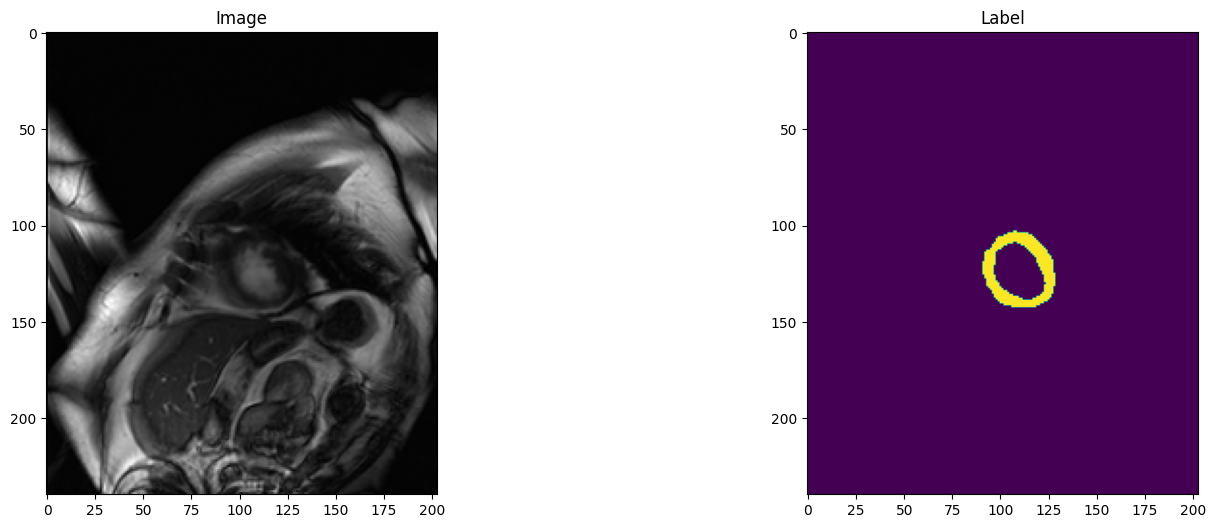

In [7]:
import os
import matplotlib.pyplot as plt
import torch

# Assuming val_ds is your dataset and json_data has been loaded as per your earlier code
# Also, assuming the dataset paths are as follows
validation_images = [
    "D:/master/1st_semester/Deep_Learning/project/DeepM/imagesTr/DET0042401_avg.nii.gz",
    "D:/master/1st_semester/Deep_Learning/project/DeepM/imagesTr/DET0042501_avg.nii.gz",
    "D:/master/1st_semester/Deep_Learning/project/DeepM/imagesTr/DET0042601_avg.nii.gz",
    "D:/master/1st_semester/Deep_Learning/project/DeepM/imagesTr/DET0043101_avg.nii.gz",
    "D:/master/1st_semester/Deep_Learning/project/DeepM/imagesTr/DET0043201_avg.nii.gz",
    "D:/master/1st_semester/Deep_Learning/project/DeepM/imagesTr/DET0044601_avg.nii.gz",
]

# Create a map of the image names to slice indices for these files
slice_map = {
    "det0042401_avg.nii.gz": 10,
    "det0042501_avg.nii.gz": 15,
    "det0042601_avg.nii.gz": 20,
    "det0043101_avg.nii.gz": 25,
    "det0043201_avg.nii.gz": 30,
    "det0044601_avg.nii.gz": 5,
}

# Index of the case you want to visualize
case_num = 5  # Replace with the desired case number (index)

# Get the image and label from the dataset
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img_name = img_name.lower()  # Normalize the case of the filename
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]

# Debugging: Print paths and shapes
print(f"Image path: {img_name}")
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

# Check if img and label are tensors
if isinstance(img, torch.Tensor):
    print("Image is a PyTorch tensor.")
else:
    print("Image is NOT a PyTorch tensor.")

if isinstance(label, torch.Tensor):
    print("Label is a PyTorch tensor.")
else:
    print("Label is NOT a PyTorch tensor.")

# Ensure that the index is within bounds
slice_idx = slice_map.get(img_name, None)

if slice_idx is None:
    print(f"Image {img_name} not found in slice_map. Please check the slice_map.")
else:
    # Ensure slice_idx is valid and within the depth range of the image
    if 0 <= slice_idx < img.shape[3]:  # img.shape[3] is the depth (31)
        print(f"Using slice index {slice_idx} for image {img_name}.")
        
        # Plot the image and the label
        plt.figure("image", (18, 6))

        # Plot the image
        plt.subplot(1, 2, 1)
        plt.title("Image")
        # Access the correct slice using the depth dimension (index 3)
        plt.imshow(img[0, :, :, slice_idx].detach().cpu(), cmap="gray")

        # Plot the label
        plt.subplot(1, 2, 2)
        plt.title("Label")
        # Access the correct slice for the label too
        plt.imshow(label[0, :, :, slice_idx].detach().cpu())

        plt.show()
    else:
        print(f"Slice index {slice_idx} is out of bounds. Valid range: 0 to {img.shape[3] - 1}")


## Create Model, Loss, Optimizer

In [8]:
import torch
import os
from monai.networks.nets import UNETR
from monai.losses import DiceCELoss

# Set CUDA device order and initialize device
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

# Define the UNETR model
model = UNETR(
    in_channels=1,
    out_channels=14,
    img_size=(64, 64, 64),
    feature_size=8,
    hidden_size=256,
    mlp_dim=1024,
    num_heads=8,
    norm_name="instance",  # Removed proj_type
    res_block=True,
    dropout_rate=0.0,
).to(device)

# Loss function
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)

# Optimizer
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


## Execute a typical PyTorch training process

In [16]:
# Mixed precision setup, only enable if CUDA is available
scaler = None
if torch.cuda.is_available():
    scaler = torch.cuda.amp.GradScaler()

# Validation function
def validation(epoch_iterator_val):
    model.eval()
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

# Training function with gradient accumulation
accumulation_steps = 2  # Adjust based on memory constraints

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = batch["image"].to(device), batch["label"].to(device)
        
        # Mixed precision forward pass only if CUDA is available
        if torch.cuda.is_available():
            with torch.cuda.amp.autocast():  # Mixed precision
                logit_map = model(x)
                loss = loss_function(logit_map, y)
        else:
            # Regular forward pass if CUDA is not available
            logit_map = model(x)
            loss = loss_function(logit_map, y)

        # Gradient accumulation
        if torch.cuda.is_available():
            # Backward pass with scaling for mixed precision
            scaler.scale(loss).backward()  
        else:
            # Regular backward pass if not using mixed precision
            loss.backward()

        if (step + 1) % accumulation_steps == 0 or (step + 1) == len(epoch_iterator):
            if torch.cuda.is_available():
                scaler.step(optimizer)  # Optimizer step with scaler
                scaler.update()  # Update the scaler
            else:
                optimizer.step()  # Normal optimizer step for CPU
            optimizer.zero_grad()

        epoch_loss += loss.item()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss.item():.5f})")

        # Validation and checkpoint saving
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)

            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(f"Model Saved! Best Avg. Dice: {dice_val_best} Current Avg. Dice: {dice_val}")
            else:
                print(f"Model Not Saved. Best Avg. Dice: {dice_val_best} Current Avg. Dice: {dice_val}")

            # Free GPU memory after validation
            torch.cuda.empty_cache()

        global_step += 1
    return global_step, dice_val_best, global_step_best

# Training loop
max_iterations = 10000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)

# Load the best model after training
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Training (X / X Steps) (loss=X.X):   0%|          | 0/83 [00:00<?, ?it/s]

Training (500 / 10000 Steps) (loss=3.38733):   4%|▎         | 3/83 [01:02<30:31, 22.90s/it]

Model Saved! Best Avg. Dice: 0.03434223681688309 Current Avg. Dice: 0.03434223681688309


Training (1000 / 10000 Steps) (loss=3.15591):   6%|▌         | 5/83 [01:08<22:15, 17.12s/it]

Model Saved! Best Avg. Dice: 0.44311344623565674 Current Avg. Dice: 0.44311344623565674


Training (1500 / 10000 Steps) (loss=2.96808):   8%|▊         | 7/83 [01:15<19:12, 15.17s/it]

Model Saved! Best Avg. Dice: 0.487321138381958 Current Avg. Dice: 0.487321138381958


Training (2000 / 10000 Steps) (loss=2.77618):  11%|█         | 9/83 [01:21<17:18, 14.03s/it]

Model Saved! Best Avg. Dice: 0.4925003945827484 Current Avg. Dice: 0.4925003945827484


Training (2500 / 10000 Steps) (loss=2.62747):  13%|█▎        | 11/83 [01:29<16:58, 14.14s/it]

Model Saved! Best Avg. Dice: 0.4941156804561615 Current Avg. Dice: 0.4941156804561615


Training (3000 / 10000 Steps) (loss=2.45795):  16%|█▌        | 13/83 [01:35<15:49, 13.57s/it]

Model Saved! Best Avg. Dice: 0.4949674904346466 Current Avg. Dice: 0.4949674904346466


Training (3500 / 10000 Steps) (loss=2.31723):  18%|█▊        | 15/83 [01:40<15:08, 13.36s/it]

Model Saved! Best Avg. Dice: 0.49502941966056824 Current Avg. Dice: 0.49502941966056824


Training (4000 / 10000 Steps) (loss=2.19853):  20%|██        | 17/83 [01:48<14:41, 13.35s/it]

Model Saved! Best Avg. Dice: 0.5006895661354065 Current Avg. Dice: 0.5006895661354065


Training (4500 / 10000 Steps) (loss=1.98374):  23%|██▎       | 19/83 [01:56<14:19, 13.43s/it]

Model Saved! Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.5090838074684143


Training (5000 / 10000 Steps) (loss=1.79357):  25%|██▌       | 21/83 [01:58<13:35, 13.16s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.5068376660346985


Training (5500 / 10000 Steps) (loss=1.62154):  28%|██▊       | 23/83 [02:21<14:33, 14.55s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.498075395822525


Training (6000 / 10000 Steps) (loss=1.45777):  30%|███       | 25/83 [02:15<12:56, 13.39s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.49892517924308777


Training (6500 / 10000 Steps) (loss=1.37018):  33%|███▎      | 27/83 [02:21<12:20, 13.23s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.4971281588077545


Training (7000 / 10000 Steps) (loss=1.21101):  35%|███▍      | 29/83 [02:28<11:54, 13.23s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.4977746307849884


Training (7500 / 10000 Steps) (loss=1.14572):  37%|███▋      | 31/83 [02:37<11:40, 13.47s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.4981612265110016


Training (8000 / 10000 Steps) (loss=1.13061):  40%|███▉      | 33/83 [02:48<11:25, 13.70s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.5010077953338623


Training (8500 / 10000 Steps) (loss=1.06634):  42%|████▏     | 35/83 [02:50<11:10, 13.98s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.4975155293941498


Training (9000 / 10000 Steps) (loss=1.04115):  45%|████▍     | 37/83 [02:50<10:01, 13.08s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.4988536834716797


Training (9500 / 10000 Steps) (loss=1.00770):  47%|████▋     | 39/83 [02:58<09:42, 13.23s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.49895766377449036


Training (10000 / 10000 Steps) (loss=0.99876):  49%|████▉     | 41/83 [03:10<09:43, 13.89s/it]

Model Not Saved. Best Avg. Dice: 0.5090838074684143 Current Avg. Dice: 0.4991593360900879


Training (10042 / 10000 Steps) (loss=0.99142): 100%|██████████| 83/83 [05:41<00:00,  4.12s/it]
C:\Users\Amin-\AppData\Local\Temp\ipykernel_21212\1328456542.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues rel

<All keys matched successfully>

## Plot the loss and metric

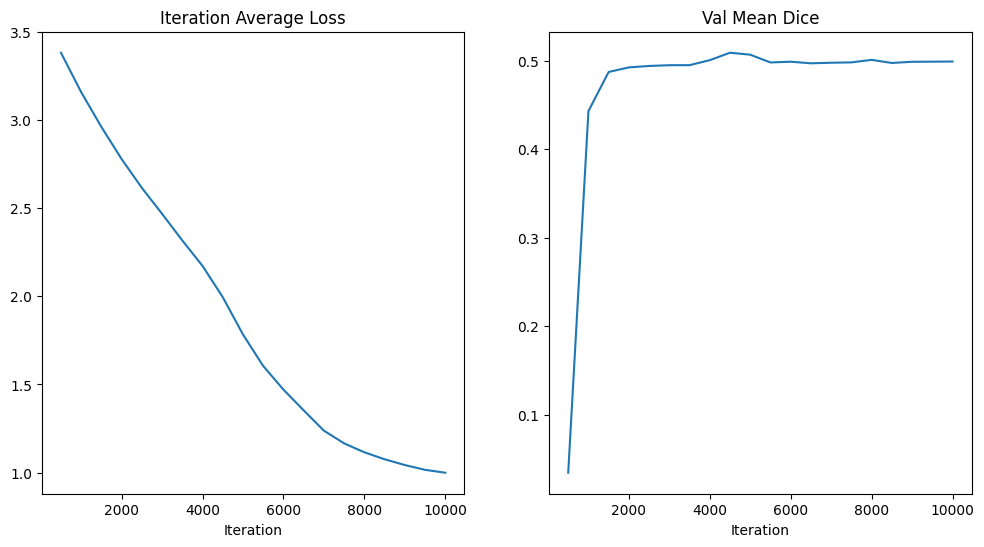

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

No surprises when you visualize the image and the label as well as the output to be not in a height resolution, as we're working with (64,64,64) image size with the transformation!

C:\Users\Amin-\AppData\Local\Temp\ipykernel_19508\2684869101.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "bes

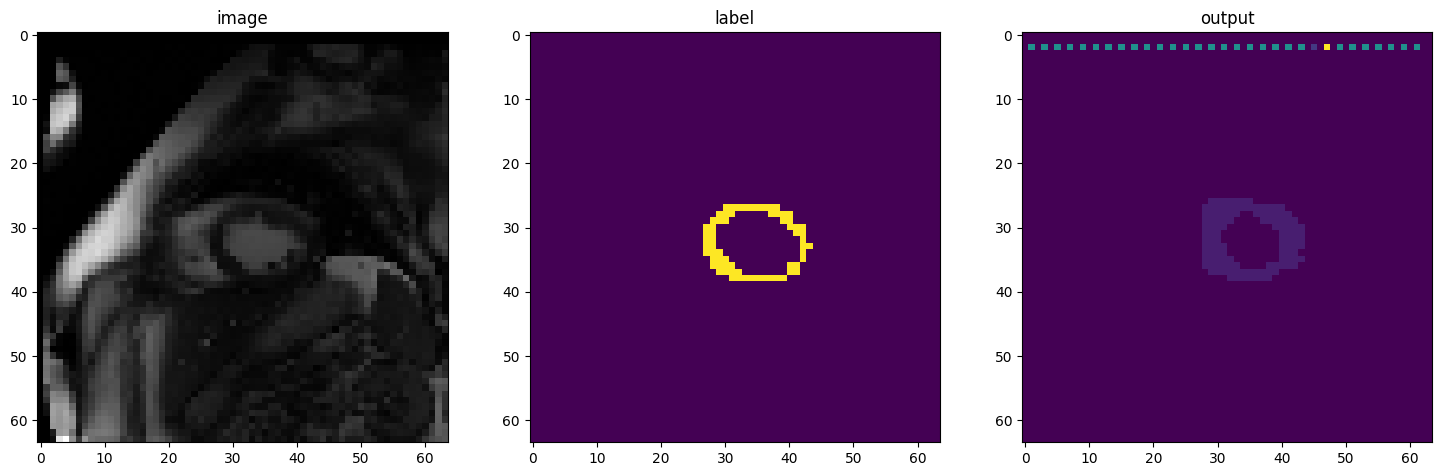

In [13]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

case_num = 4
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).to(device)
    val_labels = torch.unsqueeze(label, 1).to(device)
    val_outputs = sliding_window_inference(val_inputs, (64, 64, 64), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.to(device).numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.to(device).numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().to(device)[0, :, :, slice_map[img_name]])
    plt.show()

## Evaluation of The Model

In [107]:
import torch
import numpy as np
import os
from sklearn.metrics import f1_score, mean_squared_error, confusion_matrix, recall_score, precision_score
import warnings

# Suppress UserWarnings (which includes UndefinedMetricWarning)
warnings.simplefilter("ignore", category=UserWarning)

# Assuming model is already defined and pretrained
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth"), weights_only=True))
model.eval()

# Initialize metric trackers
all_labels = []
all_preds = []

# Variables to accumulate MSE, RMSE, IoU, Recall, and Precision across all batches
mse_total = 0
rmse_total = 0
iou_total = 0
recall_total = 0
precision_total = 0
batch_count = 0

# IoU calculation function
def iou_score(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    return intersection / (union + 1e-6)  # Add a small value to avoid division by zero

# Loop through the validation data loader
for val_data in val_loader:
    val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)

    # Forward pass to get predictions
    with torch.no_grad():
        val_outputs = model(val_inputs)

    # Convert predictions to class labels (for evaluation metrics)
    val_preds = torch.argmax(val_outputs, dim=1).cpu().numpy()  # for multi-class
    val_labels_np = val_labels.cpu().numpy()

    # Collect the ground truth and predicted labels
    all_labels.append(val_labels_np)
    all_preds.append(val_preds)

    # MSE and RMSE (accumulate for the final calculation)
    mse = mean_squared_error(val_labels_np.flatten(), val_preds.flatten())
    rmse = np.sqrt(mse)
    mse_total += mse
    rmse_total += rmse

    # F1 Score (weighted)
    f1 = f1_score(val_labels_np.flatten(), val_preds.flatten(), average="weighted")

    # Recall (weighted)
    recall = recall_score(val_labels_np.flatten(), val_preds.flatten(), average="weighted", zero_division=0)
    recall_total += recall

    # Precision (weighted)
    precision = precision_score(val_labels_np.flatten(), val_preds.flatten(), average="weighted", zero_division=0)
    precision_total += precision

    # For IoU (binary segmentation or multi-class segmentation)
    # Assuming binary segmentation or we calculate IoU per class in multi-class
    if val_labels.size(1) == 1:  # Binary segmentation (single channel output)
        pred = torch.sigmoid(val_outputs)  # Apply sigmoid for binary segmentation (logits)
        pred = (pred > 0.5).float()  # Threshold at 0.5 for binary prediction
        iou = iou_score(pred, val_labels)  # Calculate IoU
    else:  # Multi-class case, calculate IoU per class
        # Loop through each class
        iou = 0
        num_classes = val_labels.max().item() + 1  # Get number of classes
        for class_id in range(num_classes):
            pred_class = (val_preds == class_id).astype(np.float32)
            target_class = (val_labels_np == class_id).astype(np.float32)
            iou_class = iou_score(torch.tensor(pred_class), torch.tensor(target_class))
            iou += iou_class
        iou /= num_classes  # Average IoU over all classes

    iou_total += iou.item()  # Accumulate IoU for averaging

    batch_count += 1  # Count number of batches

# After looping through all batches, calculate overall metrics
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# Calculate overall Recall score (weighted)
overall_recall = recall_score(all_labels.flatten(), all_preds.flatten(), average="weighted")
print(f"Overall Recall Score: {overall_recall:.4f}")

# Calculate overall Precision score (weighted)
overall_precision = precision_score(all_labels.flatten(), all_preds.flatten(), average="weighted", zero_division=0)
print(f"Overall Precision Score: {overall_precision:.4f}")

# Calculate overall F1 score (weighted)
overall_f1 = f1_score(all_labels.flatten(), all_preds.flatten(), average="weighted")
print(f"Overall F1 Score: {overall_f1:.4f}")

# Calculate average MSE and RMSE across all batches
average_mse = mse_total / batch_count
average_rmse = rmse_total / batch_count
print(f"Average MSE: {average_mse:.4f}")
print(f"Average RMSE: {average_rmse:.4f}")

# Calculate average IoU across all batches
average_iou = iou_total / batch_count
print(f"Average IoU Score: {average_iou:.4f}")

# Optionally, print the confusion matrix for the whole validation set
cm = confusion_matrix(all_labels.flatten(), all_preds.flatten())
print(f"Confusion Matrix:\n{cm}")


Overall Recall Score: 0.9763
Overall Precision Score: 0.9917
Overall F1 Score: 0.9832
Average MSE: 0.7382
Average RMSE: 0.8562
Average IoU Score: 0.0160
Confusion Matrix:
[[1518326   19153     455     469    8923       1    5639]
 [   2605   17293       0       0       0       0       0]
 [      0       0       0       0       0       0       0]
 [      0       0       0       0       0       0       0]
 [      0       0       0       0       0       0       0]
 [      0       0       0       0       0       0       0]
 [      0       0       0       0       0       0       0]]


# Section 3: Conclusion

Despite the lack of resources to train the model, which led us to reduce the complexity of the network, reduce the image size, as well as the max_iterations during the training, we could achieve a good results interpreted from the Recall, Precision, F1 scores. Adding to that the avg of MSE, RMSE, and the confusion matrix results.

Still our model lacks the ability to work with high-dimensional images also the mean dice value is still not that high compared to the baseline model, but as soon as we get the needed computational resources to do the training, we can stick with the setup of the baseline model and we can achieve good results with that.